In [1]:
import torch

from tqdm.auto import tqdm

from point_e.diffusion.configs import diffusion_from_config
from point_e.models.configs import model_from_config
from point_e.config import MODEL_CONFIGS,DIFFUSION_CONFIGS

from point_e.utils.download import load_checkpoint
from point_e.diffusion.sampler import PointCloudSampler
from point_e.utils.plotting import plot_point_cloud

/home/aioz-nghiale/anaconda3/envs/point_e_revised/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
guidance_scale = [3.0, 0.0]
num_points=[1024, 4096 - 1024]

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=num_points,
    aux_channels=['R', 'G', 'B'],
    guidance_scale=guidance_scale,
    model_kwargs_key_filter=('images', ''), # Do not condition the upsampler at all
    use_karras = (False,False)
)

In [4]:
pre_noise = []
for (stage_pt,guide_scale) in zip(num_points,guidance_scale):
    batch_size = 1
    sample_shape = (batch_size, 3 + len(sampler.aux_channels), stage_pt)
    internal_batch_size = batch_size
    if guide_scale:
        internal_batch_size *= 2
    pre_noise.append(
        torch.randn(*(internal_batch_size, *sample_shape[1:]))
    )

In [5]:
len(pre_noise)

2

In [ ]:
from PIL import Image
# Set a prompt to condition on.
img = Image.open('asset/xeno.jpg')

# Produce a sample from the model.
samples_set = []
final_sample = None
count = 0
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]),pre_noise=pre_noise)):
    if count%128 == 0: samples_set.append(x)
    final_sample = x
    count+=1

samples_set.append(final_sample)
len(samples_set)

1024it [00:44, 22.69it/s]

done with one


2048it [03:27,  9.86it/s]

done with one


In [8]:
from point_e.utils.point_cloud import PointCloud
from point_e.utils.path import LOG_DIR
import os

pc_set = [sampler.output_to_point_clouds(sample)[0] for sample in samples_set]

PointCloud.write_batch_ply(pc_set,'xeno')

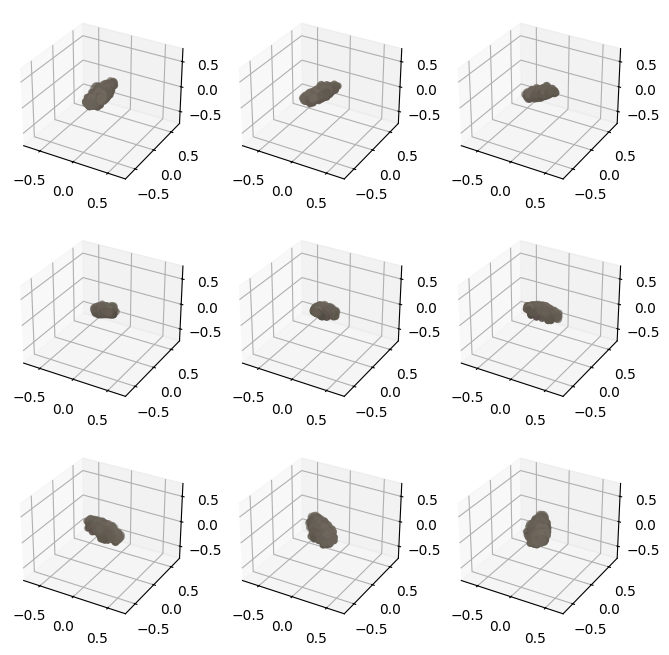

In [9]:
pc = sampler.output_to_point_clouds(samples_set[1])[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [10]:
pre_noise

[tensor([[[ 0.7546,  0.6041,  0.9160,  ..., -0.5410, -1.3729,  1.0671],
          [-0.6324, -1.0275,  1.4707,  ..., -0.5486,  0.8441, -0.0220],
          [-0.4559,  0.4616,  0.4090,  ...,  0.5754, -0.8784,  0.1155],
          [ 0.6265, -0.2583, -0.8509,  ...,  0.2469,  0.2802, -0.7268],
          [-0.7940, -0.9344,  0.4496,  ..., -0.0299, -0.9684, -0.1646],
          [-1.1865, -0.1380,  0.6737,  ...,  0.8250, -0.8499, -0.4991]],
 
         [[ 0.5944,  0.2348, -1.4444,  ...,  1.4131,  1.1792,  1.1315],
          [ 0.4070,  0.6044, -0.0065,  ..., -1.1479,  0.0879, -0.7403],
          [-0.7658,  0.9093,  0.7229,  ...,  0.3811,  0.5689, -2.8602],
          [-1.1843, -0.1937,  0.5998,  ...,  0.9227, -0.3739,  2.3842],
          [ 1.2077,  1.1223, -0.1054,  ...,  0.5863, -1.6102, -1.4054],
          [-1.0433, -1.0726,  0.5223,  ...,  0.9827,  0.9024,  1.1654]]]),
 tensor([[[-2.4850, -1.2891,  0.5421,  ..., -0.3796, -0.4538, -0.3049],
          [-1.6303, -0.0768, -0.3360,  ..., -0.7377,  1.80